In [1]:
import sys
sys.path.insert(0, "../source/")
import pyomo
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import cyipopt
import pyomo.environ as pyenv
import pyomo.gdp as pygdp
from scipy.integrate import RK45

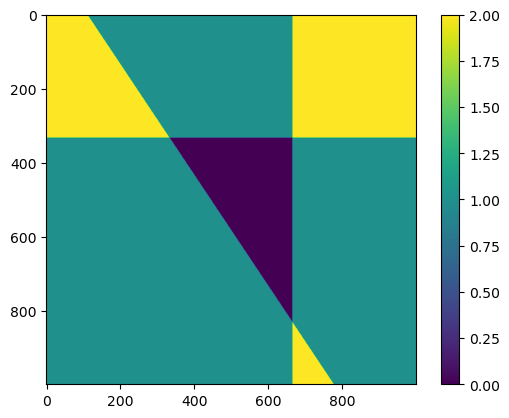

In [2]:
# polygon obstacle
class polygon_obstacle:
    def __init__(self, vertices):
        """
        :param vertices:  polygon vertices in clockwise order
        """
        self.vertices = np.array(vertices)

    def unit_vec(self, vector):
        return vector/np.linalg.norm(vector)

    @property
    def side_vectors(self):
        """Unit vectors along perimeter of polygon"""
        return np.array([
            self.unit_vec(self.vertices[i] - self.vertices[i - 1]) for i in range(len(self.vertices))
        ])

    @property
    def orthogonal_vectors(self):
        """Unit normal vectors for polygon sides"""
        return np.array([
            np.array([-v[1], v[0]]) for v in self.side_vectors
        ])

    @property
    def constants(self):
        """
        orthogonal . x >= constant
        """
        return np.array([
            np.dot(vertex, v) for vertex, v in zip(self.vertices, self.orthogonal_vectors)
        ])

polygon = polygon_obstacle([[0, 0], [1, 1.5], [1, 0]])

x = np.linspace(-1, 2, 1000)
y = np.linspace(-1, 2, 1000)
X, Y = np.meshgrid(x, y)
Z = np.zeros(X.shape)
for v, c in zip(polygon.orthogonal_vectors, polygon.constants):
    Z += (v[0]*X + v[1]*Y >= c)
plt.figure()
plt.imshow(Z)
plt.colorbar()

# Pyomo DAE

In [3]:
model = pyenv.ConcreteModel()

x0 = 0.8
y0 = 0.7
theta0 = 0.0
x_final = 0.0
y_final = 0.0
theta_final = np.pi

M = 10

regularization = 0.1

# Obstacles
cxs = [0.5, 0.4, 0.0]
cys = [0.5, 0.0, 0.1]
rs = [0.25, 0.15, 0.09]
obstacle_shape = "circle"

# bounds
x_lower = 0
x_upper = 1
y_lower = 0
y_upper = 1
v_lower = 0.0
v_upper = 1
acc_lower = -10
acc_upper = 10
omega_lower = -100*np.pi
omega_upper = 100*np.pi
omega_acc_lower = -100
omega_acc_upper = 100

model.T = 4  # final time
model.NK = 100  # number of time steps
model.h = model.T/model.NK  # time grid spacing
model.K = pyenv.RangeSet(model.NK)
model.K0 = pyenv.RangeSet(0, model.NK)
model.Km1 = pyenv.RangeSet(model.NK - 1)  # [1, NK - 1]
model.K0m1 = pyenv.RangeSet(0, model.NK - 1)  # [1, NK - 1]
model.K0m2 = pyenv.RangeSet(0, model.NK - 2)  # [1, NK - 1]

# Initial path
initial_x = np.linspace(x0, 0.0, model.NK)
initial_y = np.linspace(y0, 0.0, model.NK)
initial_theta = np.linspace(0.2, 0.5, model.NK)
initial_theta = np.arctan2(np.diff(initial_y, append=0.),np.diff(initial_x, append=0.))
initial_v = np.ones(initial_x.shape)

# # Use previously solved path
# initial_x = x
# initial_y = y
# initial_theta = theta
# initial_v = v
# initial_omega = omega

model.x = pyenv.Var(model.K0m1, domain=pyenv.Reals, bounds=(x_lower, x_upper), initialize=dict(zip(model.K0, initial_x))) # p(t)_x
model.y = pyenv.Var(model.K0m1, domain=pyenv.Reals, bounds=(y_lower, y_upper), initialize=dict(zip(model.K0, initial_y))) # p(t)_y
model.theta = pyenv.Var(model.K0m1, domain=pyenv.Reals)  # theta can be unbounded, arctan(dy/dx)
model.v = pyenv.Var(model.K0m1, domain=pyenv.Reals, bounds=(v_lower, v_upper), initialize=dict(zip(model.K0, initial_v))) # velocity; control parameter
model.acc = pyenv.Var(model.K0m1, domain=pyenv.Reals, bounds=(acc_lower, acc_upper), initialize=dict(zip(model.K0m1, np.diff(initial_v)))) # acceleration; control parameter
model.omega = pyenv.Var(model.K0m1, domain=pyenv.Reals, bounds=(omega_lower, omega_upper)) # angular velocity; control parameter
model.omega_acc = pyenv.Var(model.K0m1, domain=pyenv.Reals, bounds=(omega_acc_lower, omega_acc_upper)) # angular acceleration; control parameter

def x_forward_Euler(model, k):
    return model.x[k + 1] - model.x[k] == model.h * model.v[k] * pyenv.cos(model.theta[k])
model.x_forward_Euler = pyenv.Constraint(model.K0m2, rule=x_forward_Euler)

def y_forward_Euler(model, k):
    return model.y[k + 1] - model.y[k] == model.h * model.v[k] * pyenv.sin(model.theta[k])
model.y_forward_Euler = pyenv.Constraint(model.K0m2, rule=y_forward_Euler)

def theta_forward_Euler(model, k):
    return model.theta[k + 1] - model.theta[k] == model.h * model.omega[k]
model.theta_forward_Euler = pyenv.Constraint(model.K0m2, rule=theta_forward_Euler)

def acceleration_forward_Euler(model, k):
    return model.v[k + 1] - model.v[k] == model.h * model.acc[k]
model.acceleration_forward_Euler = pyenv.Constraint(model.K0m2, rule=acceleration_forward_Euler)

def omega_acceleration_forward_Euler(model, k):
    return model.omega[k + 1] - model.omega[k] == model.h * model.omega_acc[k]
model.omega_acceleration_forward_Euler = pyenv.Constraint(model.K0m2, rule=omega_acceleration_forward_Euler)

def initial_x_rule(model):
    return model.x[0] == x0
model.initial_x_rule = pyenv.Constraint(rule=initial_x_rule)

def initial_y_rule(model):
    return model.y[0] == y0
model.initial_y_rule = pyenv.Constraint(rule=initial_y_rule)

def initial_theta_rule(model):
    return model.theta[0] == theta0
# model.initial_theta_rule = pyenv.Constraint(rule=initial_theta_rule)

def final_x_rule(model):
    return model.x[model.NK-1] == x_final
model.final_x_rule = pyenv.Constraint(rule=final_x_rule)

def final_y_rule(model):
    return model.y[model.NK-1] == y_final
model.final_y_rule = pyenv.Constraint(rule=final_y_rule)

# Allow for +- 2*pi
def final_theta_sin_rule(model):
    return pyenv.sin(model.theta[model.NK]) == pyenv.sin(theta_final)

def final_theta_cos_rule(model):
    return pyenv.cos(model.theta[model.NK]) == pyenv.cos(theta_final)
# model.final_theta_sin_rule = pyenv.Constraint(rule=final_theta_sin_rule)
# model.final_theta_cos_rule = pyenv.Constraint(rule=final_theta_cos_rule)

def diamond_obstacle_rule(model, k, cx, cy, r):
    """1-norm obstacle with center (cx, cy) and radius r"""
    rx = r
    ry = r
    return abs(model.x[k] - cx)/rx +  abs(model.y[k] - cy)/ry >= 1

def square_obstacle_rule(model, k, cx, cy, r):
    """1-norm obstacle rotated with center (cx, cy) and radius r"""
    rx = r
    ry = r
    return 0.5*abs((model.x[k]-cx)/rx + (model.y[k]-cy)/ry) +  0.5*abs((model.x[k]-cx)/rx - (model.y[k]-cy)/ry) >= 1

def circle_obstacle_rule(model, k, cx, cy, r):
    """Circle obstacle with center (cx, cy) and radius r"""
    rx = r
    ry = r
    return (model.x[k] - cx)**2/(rx**2) + (model.y[k] - cy)**2/(ry**2) >= 1

if obstacle_shape == "circle":
    model.circle_obstacle_rules = pyenv.ConstraintList()
    for k in model.K0m1:
        for cx, cy, r in zip(cxs, cys, rs):
            model.circle_obstacle_rules.add(
                circle_obstacle_rule(model, k, cx, cy, r)
            )
elif obstacle_shape == "square":
    model.square_obstacle_rules = pyenv.ConstraintList()
    for k in model.K0m1:
        for cx, cy, r in zip(cxs, cys, rs):
            model.square_obstacle_rules.add(
                square_obstacle_rule(model, k, cx, cy, r)
            )
elif obstacle_shape == "diamond":
    model.diamond_obstacle_rules = pyenv.ConstraintList()
    for k in model.K0m1:
        for cx, cy, r in zip(cxs, cys, rs):
            model.diamond_obstacle_rules.add(
                diamond_obstacle_rule(model, k, cx, cy, r)
            )

# poly1_vertices = [
#     [0.1, 0.0],
#     [0.1, 0.2],
#     [0.2, 0.2],
#     [0.2, 0.0]
# ]
# polygons = [
#     polygon_obstacle(poly1_vertices)
# ]

# model.Nvertices = pyenv.RangeSet(len(poly1_vertices))
# model.Y = pyenv.Var(model.Nvertices, domain=pyenv.Binary)

# model.poly_obstacle_rules = pyenv.ConstraintList()
# for poly in polygons:
#     for i, (v, c) in enumerate(zip(poly.orthogonal_vectors, poly.constants)):
#         for k in model.K:
#             model.poly_obstacle_rules.add((model.x[k]*v[0] + model.y[k]*v[1]) >= model.Y[i+1] * c - (1 - model.Y[i+1]) * M)

# def poly_obstacle_sum_rule(model):
#     return sum(model.Y[i] for i in model.Nvertices) >= 1
# model.poly_obstacle_sum_rule = pyenv.Constraint(rule = poly_obstacle_sum_rule)

def objective_func(model):
    return model.x[model.NK-1]**2 + model.y[model.NK-1]**2 + regularization/model.NK*(pyenv.sum_product(model.v, model.v) + pyenv.sum_product(model.omega, model.omega))
    # return pyenv.sum_product(model.v, model.v) + pyenv.sum_product(model.omega, model.omega)
model.objective_func = pyenv.Objective(rule=objective_func, sense=pyenv.minimize)


solver = pyenv.SolverFactory("ipopt")
solver.solve(model, tee=True)


Ipopt 3.14.12: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.12, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:     1687
Number of nonzeros in inequality constraint Jacobian.:      600
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      698
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      598
                     variables with only upper bounds:        0
Total number of equality constraints.................:      499
Total number

{'Problem': [{'Lower bound': -inf, 'Upper bound': inf, 'Number of objectives': 1, 'Number of constraints': 799, 'Number of variables': 698, 'Sense': 'unknown'}], 'Solver': [{'Status': 'ok', 'Message': 'Ipopt 3.14.12\\x3a Optimal Solution Found', 'Termination condition': 'optimal', 'Id': 0, 'Error rc': 0, 'Time': 1.6497292518615723}], 'Solution': [OrderedDict({'number of solutions': 0, 'number of solutions displayed': 0})]}

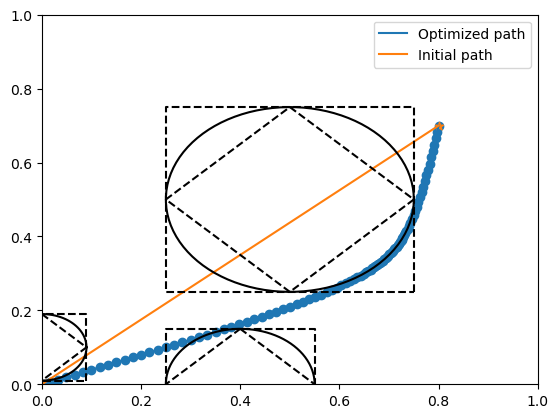

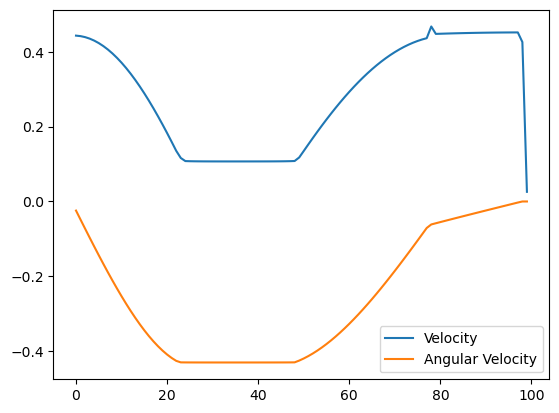

In [4]:
import matplotlib.pyplot as plt
plt.figure()

x, y, theta, v, omega = [], [], [], [], []
for k in zip(model.K0m1):
    x.append(pyenv.value(model.x[k]))
    y.append(pyenv.value(model.y[k]))
    theta.append(pyenv.value(model.theta[k]))
    v.append(pyenv.value(model.v[k]))
    omega.append(pyenv.value(model.omega[k]))
plt.plot(x, y, label="Optimized path")
plt.scatter(x, y)
plt.scatter(x[0], y[0], marker='*')
plt.xlim([-0,1])
plt.ylim([-0,1])

plt.plot(initial_x, initial_y, label="Initial path")

if obstacle_shape == "circle":
    style = 'k'
else:
    style = 'k--'
# circle
t = np.linspace(0, 2*np.pi, 100)
for cx, cy, r in zip(cxs, cys, rs):
    plt.plot(r*np.cos(t) + cx, r*np.sin(t) + cy, style)

if obstacle_shape == "diamond":
    style = 'k'
else:
    style = 'k--'
# diamond
for cx, cy, r in zip(cxs, cys, rs):
    plt.plot([cx, cx + r, cx, cx - r, cx], [cy + r, cy, cy - r, cy, cy + r], style)

if obstacle_shape == "square":
    style = 'k'
else:
    style = 'k--'
# square
for cx, cy, r in zip(cxs, cys, rs):
    plt.plot([cx + r, cx + r, cx - r, cx - r, cx + r], [cy -r, cy + r, cy + r, cy - r, cy - r], style)

# for poly in polygons:
#     plt.plot(poly.vertices[:,0], poly.vertices[:,1])

plt.legend()

plt.figure()
plt.plot(v, label="Velocity")
plt.plot(omega, label="Angular Velocity")
plt.legend()

Solution is sensitive to initial path provided. I am not sure how IPOPT handles initial values that are inconsitent with constraints.

Unfortunately, I don't see how to get the external function of the OED objective into pyomo. It might be better to interface directly with IPOPT.

# Direct IPOPT optimization: Example Rosenbrock function
If we use `cyipopt`, we can specify the objective function value and a gradient function, but we have to handle the constraints ourselves.

In [5]:
# Define the objective function
def rosenbrock(x, user_data=None):
    x1 = x[0]
    x2 = x[1]
    return (1 - x[0])**2 + 100 * (x[1] - x[0]**2)**2

class Objective:
    def objective(self, x):
        return rosenbrock(x, user_data=None)
    def gradient(self, x):
        """Objective function gradient"""
        return jax.grad(self.objective)(x)
    def constraints(self, x):
        """Values to constrain between cl and cu"""
        return (
            (x[0] - 1)**2 + (x[1] - 1)**2,
            x[0]
        )
    def jacobian(self, x):
        """Jacobian of constraints"""
        return jax.jacfwd(self.constraints)(x)
        
problem_obj = Objective()

print(f"objective: {problem_obj.objective([1.2,1.])}\ngradient: {problem_obj.gradient([1.2,1.])}")

# Create the problem instance
problem = cyipopt.Problem(
    n=2,  # Number of decision variables
    m=2,  # Number of constraints
    problem_obj=problem_obj,  # Objective object with "objective" and "gradient" functions
    lb = [-2.0, -2.0],  # Lower bounds for x
    ub = [2.0, 2.0],  # Upper bounds for x
    cl = [0.01, 0.0], # Lower bound for constraints
    cu = [0.01, 1.5], # Lower bound for constraints
)

# Set the initial guess for the decision variables
x0 = [2.0, 1.0]

# Solve the problem
solution, info = problem.solve(x0)

# Print the solution
print(f"Solution: {solution}")
print(f"Objective value: {info['obj_val']}")

objective: 19.399999999999995
gradient: [Array(211.60004, dtype=float32, weak_type=True), Array(-88.000015, dtype=float32, weak_type=True)]

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.12, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:        2
Number of nonzeros in inequality constraint Jacobian.:        2
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        2
                

In [6]:
x0 = [1.5, 1.6]
print(f"objective: {problem_obj.objective(x0)}")
print(f"gradient: {problem_obj.gradient(x0)}")
print(f"constraints: {problem_obj.constraints(x0)}")
print(f"jacobian: {problem_obj.jacobian(x0)}")

objective: 42.499999999999986
gradient: [Array(391., dtype=float32, weak_type=True), Array(-130., dtype=float32, weak_type=True)]
constraints: (0.6100000000000001, 1.5)
jacobian: ([Array(1., dtype=float32, weak_type=True), Array(1.2, dtype=float32, weak_type=True)], [Array(1., dtype=float32, weak_type=True), Array(0., dtype=float32, weak_type=True)])


# Direct IPOPT optimization
Implement the above that was in pyomo to IPOPT directly (should let us swap the function call to something else)

In [7]:
from scipy.sparse import coo_array
from functools import cached_property

class Objective:
    def __init__(self):
        self.x0 = 0.8
        self.y0 = 0.8
        self.theta0 = 0.0
        self.x_final = 0.0
        self.y_final = 0.0
        self.theta_final = np.pi
        
        # Obstacles
        self.cxs = [0.5, 0.4, 0.0]
        self.cys = [0.5, 0.0, 0.1]
        self.rxs = [0.35, 0.15, 0.09]
        self.rys = [0.25, 0.15, 0.09]
        self.obstacle_shape = "circle"
        
        # bounds
        self.x_lower = 0
        self.x_upper = 1
        self.y_lower = 0
        self.y_upper = 1
        self.theta_lower = -1000
        self.theta_upper = 1000
        self.v_lower = 0.0
        self.v_upper = 1
        self.acc_lower = -10
        self.acc_upper = 10
        self.omega_lower = -100*np.pi
        self.omega_upper = 100*np.pi
        self.omega_acc_lower = -100
        self.omega_acc_upper = 100
        
        self.T = 4.0  # final time
        self.NK = 100  # number of time steps
        self.h = self.T/self.NK  # time grid spacing
        self.reg = 0.001  # regularization term

        self.x_shift = 0*self.NK
        self.y_shift = 1*self.NK
        self.theta_shift = 2*self.NK
        self.v_shift = 3*self.NK
        self.acc_shift = 4*self.NK
        self.omega_shift = 5*self.NK
        self.omega_acc_shift = 6*self.NK

        self.n = self.NK*7 # number of variables
        self.num_equality_constraints = (self.NK - 1) * 5 + 4
        self.m = self.num_equality_constraints + (self.NK) * len(self.cxs) # self.constraints(jnp.zeros((self.n, ))).shape[0] # number of constraints (also initializes the number of equality/inequality constraints)

    def var_joiner(self, x, y, theta, v, acc, omega, omega_acc):
        """Join variables into a single vector"""
        return jnp.concat((x, y, theta, v, acc, omega, omega_acc), axis=0)
        
    def var_splitter(self, vars):
        """Split variables from a single vector"""
        x = vars[self.x_shift:self.x_shift + self.NK]
        y = vars[self.y_shift:self.y_shift + self.NK]
        theta = vars[self.theta_shift:self.theta_shift + self.NK]
        v = vars[self.v_shift:self.v_shift + self.NK]
        acc = vars[self.acc_shift:self.acc_shift + self.NK]
        omega = vars[self.omega_shift:self.omega_shift + self.NK]
        omega_acc = vars[self.omega_acc_shift:self.omega_acc_shift + self.NK]
        # y = vars[self.NK:2*self.NK]
        # theta = vars[2*self.NK:3*self.NK]
        # v = vars[3*self.NK:4*self.NK]
        # acc = vars[4*self.NK:5*self.NK]
        # omega = vars[5*self.NK:6*self.NK]
        # omega_acc = vars[6*self.NK:7*self.NK]
        return (x, y, theta, v, acc, omega, omega_acc)
        
    @property
    def lb(self):
        """Lower bounds on variables"""
        x = self.x_lower*jnp.ones((self.NK,))
        y = self.y_lower*jnp.ones((self.NK,))
        theta = self.theta_lower*jnp.ones((self.NK,))
        v = self.v_lower*jnp.ones((self.NK,))
        acc = self.acc_lower*jnp.ones((self.NK,))
        omega = self.omega_lower*jnp.ones((self.NK,))
        omega_acc = self.omega_acc_lower*jnp.ones((self.NK,))
        return jnp.concat((x, y, theta, v, acc, omega, omega_acc), axis=0)
        
    @property
    def ub(self):
        """Upper bound on variables"""
        x = self.x_upper*jnp.ones((self.NK,))
        y = self.y_upper*jnp.ones((self.NK,))
        theta = self.theta_upper*jnp.ones((self.NK,))
        v = self.v_upper*jnp.ones((self.NK,))
        acc = self.acc_upper*jnp.ones((self.NK,))
        omega = self.omega_upper*jnp.ones((self.NK,))
        omega_acc = self.omega_acc_upper*jnp.ones((self.NK,))
        return jnp.concat((x, y, theta, v, acc, omega, omega_acc), axis=0)
        
    def objective(self, vars):
        (x, y, theta, v, acc, omega, omega_acc) = self.var_splitter(vars)
        return self.reg*(jnp.sum(v**2) + jnp.sum(omega**2))
        
    def gradient(self, vars):
        """Objective function gradient"""
        return jax.grad(self.objective)(vars)

    def circle_obstacle(self, x, y, cx, cy, rx, ry):
        """Circular obstacle"""
        return ((x - cx)/rx)**2 + ((y - cy)/ry)**2 - 1

    def diamond_obstacle(self, x, y, cx, cy, rx, ry):
        """Diamond obstacle"""
        return jnp.abs((x - cx)/rx) + jnp.abs((y - cy)/ry) - 1

    def square_obstacle(self, x, y, cx, cy, rx, ry):
        """Square obstacle"""
        return jnp.abs(((x - cx)/rx + (y - cy)/ry)/2) + jnp.abs(((x - cx)/rx - (y - cy)/ry)/2) - 1

    # @jax.jit
    def constraints(self, vars):
        """Values to constrain between cl and cu"""
        # Equality constraints
        (x, y, theta, v, acc, omega, omega_acc) = self.var_splitter(vars)
        dae_x = (x[1:] - x[:-1]) - self.h * jnp.cos(theta[:-1]) * v[:-1] # == 0
        dae_y = (y[1:] - y[:-1]) - self.h * jnp.sin(theta[:-1]) * v[:-1] # == 0
        dae_theta = (theta[1:] - theta[:-1]) - self.h * omega[:-1] # == 0
        dae_acc = (v[1:] - v[:-1]) - self.h * acc[:-1] # == 0
        dae_omega_acc = (omega[1:] - omega[:-1]) - self.h * omega_acc[:-1] # == 0
        initial_x = x[0] - self.x0 # == 0
        initial_y = y[0] - self.y0 # == 0
        final_x = x[-1] - self.x_final # == 0
        final_y = y[-1] - self.y_final # == 0
        cons = jnp.concat((dae_x, dae_y, dae_theta, dae_acc, dae_omega_acc, jnp.array((initial_x, initial_y, final_x, final_y))), axis = 0)
        # cons = jnp.concat((dae_x, dae_y, dae_theta, jnp.array((initial_x, initial_y, final_x, final_y))), axis = 0)
        self.num_equality_constraints = len(cons)
        
        # Inequality contraints
        for (cx, cy, rx, ry) in zip(self.cxs, self.cys, self.rxs, self.rys):
            cons = jnp.concat((cons, self.circle_obstacle(x, y, cx, cy, rx, ry))) # >= 0
        return cons

    @property
    def cl(self):
        """Constriant lower bounds"""
        return jnp.zeros((self.m,))

    @property
    def cu(self):
        """Constraint upper bounds"""
        upper_bound = np.zeros((self.m,))
        upper_bound[self.num_equality_constraints:] = 1000000
        return upper_bound

    
    def jacobianstructure(self):
        return self.memoized_jac_structure
    
    @cached_property
    def memoized_jac_structure(self) -> tuple[jnp.ndarray,jnp.ndarray]:
        # (x, y, theta, v, acc, omega, omega_acc) = self.var_splitter(vars)
        # return jax.experimental.sparse.jacfwd(self.contraints)(x)
        # return jax.jacfwd(self.constraints)(vars)
        rows = []
        columns = []
        # values = []
        row = 0
        for i in range(self.NK - 1):
            columns += [i + 1 + self.x_shift, i + self.x_shift, i + self.theta_shift, i + self.v_shift]
            rows += [row]*4
            # values += [1, -1, self.h * jnp.sin(theta[i]) * v[i], -self.h * jnp.cos(theta[i])]
            row += 1
        for i in range(self.NK - 1):
            columns += [i + 1 + self.y_shift, i + self.y_shift, i + self.theta_shift, i + self.v_shift]
            rows += [row]*4
            # values += [1, -1, -self.h * jnp.cos(theta[i]) * v[i], -self.h * jnp.sin(theta[i])]
            row += 1
        for i in range(self.NK - 1):
            columns += [i + 1 + self.theta_shift, i + self.theta_shift, i + self.omega_shift]
            rows += [row]*3
            # values += [1, -1, -self.h]
            row += 1
        for i in range(self.NK - 1):
            columns += [i + 1 + self.v_shift, i + self.v_shift, i + self.acc_shift]
            rows += [row]*3
            # values += [1, -1, -self.h]
            row += 1
        for i in range(self.NK - 1):
            columns += [i + 1 + self.omega_shift, i + self.omega_shift, i + self.omega_acc_shift]
            rows += [row]*3
            # values += [1, -1, -self.h]
            row += 1
        # Initial x
        columns += [0 + self.x_shift]
        rows += [row]
        # values += [1]
        row += 1
        # Initial y
        columns += [0 + self.y_shift]
        rows += [row]
        # values += [1]
        row += 1
        # Final x
        columns += [self.NK - 1 + self.x_shift]
        rows += [row]
        # values += [1]
        row += 1
        # Final y
        columns += [self.NK - 1 + self.y_shift]
        rows += [row]
        # values += [1]
        row += 1
        # ((x - cx)/rx)**2 + ((y - cy)/ry)**2 - 1
        for (cx, cy, rx, ry) in zip(self.cxs, self.cys, self.rxs, self.rys):
            for i in range(self.NK):
                columns += [i + self.x_shift, i + self.y_shift]
                rows += [row]*2
                # values += [2/rx*(x[i]-cx)/rx, 2/ry*(y[i]-cy)/ry]
                row += 1
        return (jnp.array(rows, dtype=int), jnp.array(columns, dtype=int))

    # # @jax.jit
    # def jacobian(self, vars):
    #     """Jacobian of constraints"""
    #     (x, y, theta, v, acc, omega, omega_acc) = self.var_splitter(vars)
    #     # return jax.experimental.sparse.jacfwd(self.contraints)(x)
    #     # return jax.jacfwd(self.constraints)(vars)
    #     # rows = []
    #     # columns = []
    #     values = []
    #     # row = 0
    #     for i in range(self.NK - 1):
    #         # columns += [i + 1 + self.x_shift, i + self.x_shift, i + self.theta_shift, i + self.v_shift]
    #         # rows += [row]*4
    #         values += [1, -1, self.h * jnp.sin(theta[i]) * v[i], -self.h * jnp.cos(theta[i])]
    #         # row += 1
    #     for i in range(self.NK - 1):
    #         # columns += [i + 1 + self.y_shift, i + self.y_shift, i + self.theta_shift, i + self.v_shift]
    #         # rows += [row]*4
    #         values += [1, -1, -self.h * jnp.cos(theta[i]) * v[i], -self.h * jnp.sin(theta[i])]
    #         # row += 1
    #     for i in range(self.NK - 1):
    #         # columns += [i + 1 + self.theta_shift, i + self.theta_shift, i + self.omega_shift]
    #         # rows += [row]*3
    #         values += [1, -1, -self.h]
    #         # row += 1
    #     for i in range(self.NK - 1):
    #         # columns += [i + 1 + self.v_shift, i + self.v_shift, i + self.acc_shift]
    #         # rows += [row]*3
    #         values += [1, -1, -self.h]
    #         # row += 1
    #     for i in range(self.NK - 1):
    #         # columns += [i + 1 + self.omega_shift, i + self.omega_shift, i + self.omega_acc_shift]
    #         # rows += [row]*3
    #         values += [1, -1, -self.h]
    #         # row += 1
    #     # Initial x
    #     # columns += [0 + self.x_shift]
    #     # rows += [row]
    #     values += [1]
    #     # row += 1
    #     # Initial y
    #     # columns += [0 + self.y_shift]
    #     # rows += [row]
    #     values += [1]
    #     # row += 1
    #     # Final x
    #     # columns += [self.NK - 1 + self.x_shift]
    #     # rows += [row]
    #     values += [1]
    #     # row += 1
    #     # Final y
    #     # columns += [self.NK - 1 + self.y_shift]
    #     # rows += [row]
    #     values += [1]
    #     # row += 1
    #     # ((x - cx)/rx)**2 + ((y - cy)/ry)**2 - 1
    #     for (cx, cy, rx, ry) in zip(self.cxs, self.cys, self.rxs, self.rys):
    #         for i in range(self.NK):
    #             # columns += [i + self.x_shift, i + self.y_shift]
    #             # rows += [row]*2
    #             values += [2*(x[i]-cx)/(rx**2), 2*(y[i]-cy)/(ry**2)]
    #             # values += [jnp.sign(x[i]-cx)/(rx), jnp.sign(y[i]-cy)/(ry)]
    #             # row += 1
    #     return np.array(values)
    #     # return coo_array((values, (rows, columns)))
    #     # output = np.zeros((self.m, self.n))
    #     # for i, j, v in zip(rows, columns, values):
    #     #     output[i,j] = v
    #     # return output[rows,columns]
    #     # rows, columns = self.jacobianstructure()
    #     # return jax.jacfwd(self.constraints)(vars)[rows,columns]

    # @jax.jit
    def jacobian(self, vars):
        """Jacobian of constraints"""
        (x, y, theta, v, acc, omega, omega_acc) = self.var_splitter(vars)
        rows, columns = self.jacobianstructure()
        values = np.zeros(rows.shape)
        index = 0
        for i in range(self.NK - 1):
            values[index:index + 4] = [1, -1, self.h * jnp.sin(theta[i]) * v[i], -self.h * jnp.cos(theta[i])]
            index += 4
        for i in range(self.NK - 1):
            values[index:index + 4] = [1, -1, -self.h * jnp.cos(theta[i]) * v[i], -self.h * jnp.sin(theta[i])]
            index += 4
        for i in range(self.NK - 1):
            values[index:index + 3] = [1, -1, -self.h]
            index += 3
        for i in range(self.NK - 1):
            values[index:index + 3] = [1, -1, -self.h]
            index += 3
        for i in range(self.NK - 1):
            values[index:index + 3] = [1, -1, -self.h]
            index += 3
        # Initial x
        values[index] = 1
        index += 1
        # Initial y
        values[index] = 1
        index += 1
        # Final x
        values[index] = 1
        index += 1
        # Final y
        values[index] = 1
        index += 1

        for (cx, cy, rx, ry) in zip(self.cxs, self.cys, self.rxs, self.rys):
            for i in range(self.NK):
                values[index:index + 2] = [2*(x[i]-cx)/(rx**2), 2*(y[i]-cy)/(ry**2)]
                index += 2
        return values

    def hessianstructure(self):
        return self.memoizedhessianstructure

    @cached_property
    def memoizedhessianstructure(self):
        hess = {}
        for i in range(self.NK):
            hess[(i + self.v_shift, i + self.v_shift)] = 1
            hess[(i + self.omega_shift, i + self.omega_shift)] = 1
            # Diagonal with 2*self.reg in v and omega regions, 0 elsewhere

        for i in range(self.NK - 1):
            hess[(i + self.theta_shift, i + self.theta_shift)] = 1
            hess[(i + self.v_shift, i + self.theta_shift)] = 1
        for j, (cx, cy, rx, ry) in enumerate(zip(self.cxs, self.cys, self.rxs, self.rys)):
            for i in range(self.NK):
                hess[(i + self.x_shift, i + self.x_shift)] = hess.get((i + self.x_shift, i + self.x_shift), 0) + 1
                hess[(i + self.y_shift, i + self.y_shift)] = hess.get((i + self.y_shift, i + self.y_shift), 0) + 1
        rows = [index[0] for index in hess.keys()]
        columns = [index[1] for index in hess.keys()]
        return (np.array(rows, dtype=int), np.array(columns, dtype=int))
        
    def hessian(self, vars, lagrange, objective_factor):
        """
        Returns the non-zero values of the lagrangian Hessian.

        Lower diagonal entries only; matrix vector products;
        Arguments are:
            vars : variables
            lagrange : lagrange multipliers
            objective_factor : some representation of the objective
        """
        (x, y, theta, v, acc, omega, omega_acc) = self.var_splitter(vars)
        hess = {}
        for i in range(self.NK):
            hess[(i + self.v_shift, i + self.v_shift)] = 2 * self.reg * objective_factor #[i + self.v_shift]
            hess[(i + self.omega_shift, i + self.omega_shift)] = 2 * self.reg * objective_factor #[i + self.omega_shift]
            # Diagonal with 2*self.reg in v and omega regions, 0 elsewhere

        for i in range(self.NK - 1):
            hess[(i + self.theta_shift, i + self.theta_shift)] = self.h * jnp.cos(theta[i]) * v[i] * lagrange[i] + self.h * jnp.sin(theta[i]) * v[i] * lagrange[i + 1*(self.NK - 1)]
            hess[(i + self.theta_shift, i + self.v_shift)] = self.h * jnp.sin(theta[i]) * lagrange[i] - self.h * jnp.cos(theta[i]) * lagrange[i + 1*(self.NK - 1)]
        for j, (cx, cy, rx, ry) in enumerate(zip(self.cxs, self.cys, self.rxs, self.rys)):
            for i in range(self.NK):
                hess[(i + self.x_shift, i + self.x_shift)] = hess.get((i + self.x_shift, i + self.x_shift), 0.0) + 2/(rx**2) * lagrange[i + 4 + 5*(self.NK - 1) + j*self.NK]
                hess[(i + self.y_shift, i + self.y_shift)] = hess.get((i + self.y_shift, i + self.y_shift), 0.0) + 2/(ry**2) * lagrange[i + 4 + 5*(self.NK - 1) + j*self.NK]
        return np.array(list(hess.values()))
        # obj_hess = jax.jacrev(jax.jacfwd(self.objective)))
        # return jax.hessian(self.objective)(vars) * v[0]


In [8]:
problem_obj = Objective()

problem = cyipopt.Problem(
    n = problem_obj.n,  # Number of decision variables
    m = problem_obj.m,  # Number of constraints
    problem_obj = problem_obj,  # Objective object with "objective" and "gradient" functions
    lb = problem_obj.lb,  # Lower bounds for x
    ub = problem_obj.ub,  # Upper bounds for x
    cl = problem_obj.cl,  # Lower bound for constraints
    cu = problem_obj.cu,  # Lower bound for constraints
)

598

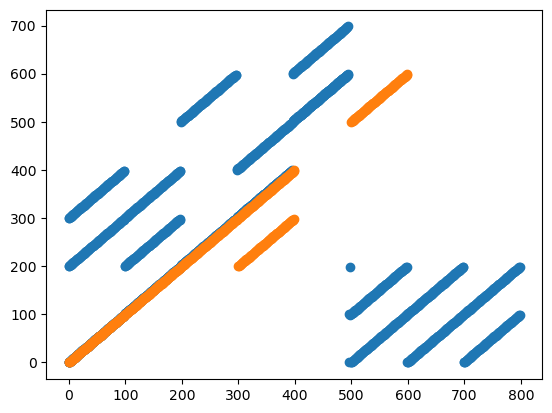

In [9]:
plt.figure()
plt.scatter(problem_obj.jacobianstructure()[0], problem_obj.jacobianstructure()[1])
plt.scatter(problem_obj.hessianstructure()[0], problem_obj.hessianstructure()[1])
len(problem_obj.jacobianstructure()[0])
len(problem_obj.hessianstructure()[0])

In [10]:
# Set the initial guess for the decision variables
initial_x = jnp.linspace(problem_obj.x0, 0.0, problem_obj.NK)
initial_y = jnp.linspace(problem_obj.y0, 0.0, problem_obj.NK)
initial_theta = jnp.arctan2(np.diff(initial_y, append=0.),np.diff(initial_x, append=0.))
initial_v = jnp.ones(initial_x.shape)
initial_acc = jnp.ones(initial_x.shape)
initial_omega = jnp.ones(initial_x.shape)
initial_omega_acc = jnp.ones(initial_x.shape)

x0 = problem_obj.var_joiner(initial_x, initial_y, initial_theta, initial_v, initial_acc, initial_omega, initial_omega_acc)

# problem.add_option("hessian_approximation", "limited-memory")
# Solve the problem
solution, info = problem.solve(x0)
# solution, info = problem.solve(solution)

# Print the solution
# print(f"Solution: {solution}")
print(f"Objective value: {info['obj_val']}")

This is Ipopt version 3.14.12, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:     1687
Number of nonzeros in inequality constraint Jacobian.:      600
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      700
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      700
                     variables with only upper bounds:        0
Total number of equality constraints.................:      499
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.9801001e-01 2.32e+00 3.87e-04  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

Use limited memory option when Hessian is not available (or difficult to get at)

We can also try changing linear solvers from mumps to something else.

The Jacobian and Hessian are very sparse, so we can exploit this to our advantage! The `hessian` and `jacobian` values are provided by the `hessian` and `jacobian` functions, only the non-zero values, and the indices `rows` and `columns` are provided by the corresponding `hessianstructure` or `jacobianstructure` functions that return `(rows, columns)`. If the structure doesn't change, this can be cached.

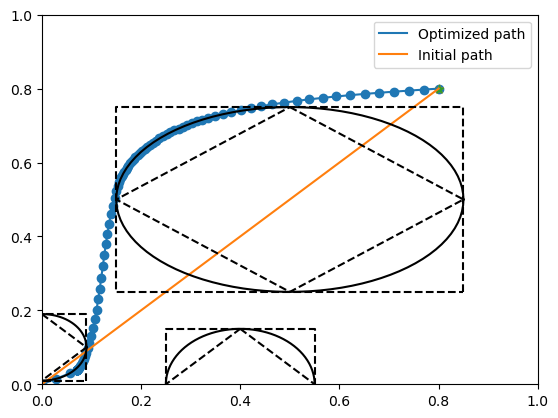

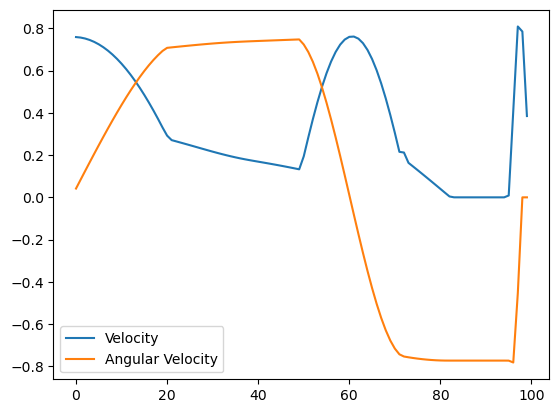

In [11]:
(x, y, theta, v, acc, omega, omega_acc) = problem_obj.var_splitter(solution)


plt.figure()
plt.plot(x, y, label="Optimized path")
plt.scatter(x, y)
plt.scatter(x[0], y[0], marker='*')
plt.scatter(problem_obj.x0, problem_obj.y0, marker='*')
plt.xlim([-0,1])
plt.ylim([-0,1])

plt.plot(initial_x, initial_y, label="Initial path")

obstacle_shape = "circle"

if obstacle_shape == "circle":
    style = 'k'
else:
    style = 'k--'
# circle
t = np.linspace(0, 2*np.pi, 100)
for cx, cy, rx, ry in zip(problem_obj.cxs, problem_obj.cys, problem_obj.rxs, problem_obj.rys):
    plt.plot(rx*np.cos(t) + cx, ry*np.sin(t) + cy, style)

if obstacle_shape == "diamond":
    style = 'k'
else:
    style = 'k--'
# diamond
for cx, cy, rx, ry in zip(problem_obj.cxs, problem_obj.cys, problem_obj.rxs, problem_obj.rys):
    plt.plot([cx, cx + rx, cx, cx - rx, cx], [cy + ry, cy, cy - ry, cy, cy + ry], style)

if obstacle_shape == "square":
    style = 'k'
else:
    style = 'k--'
# square
for cx, cy, rx, ry in zip(problem_obj.cxs, problem_obj.cys, problem_obj.rxs, problem_obj.rys):
    plt.plot([cx + rx, cx + rx, cx - rx, cx - rx, cx + rx], [cy -ry, cy + ry, cy + ry, cy - ry, cy - ry], style)

# for poly in polygons:
#     plt.plot(poly.vertices[:,0], poly.vertices[:,1])

plt.legend()

plt.figure()
plt.plot(v, label="Velocity")
plt.plot(omega, label="Angular Velocity")
plt.legend()

In [12]:
import sys
sys.path.insert(0, "../source/")
sys.path.insert(0, "../models/AdvectionDiffusion/settings/AdvectionDiffusion_FEniCS")
sys.path.insert(0, "../models/AdvectionDiffusion/Navigators")
sys.path.insert(0, "../models/AdvectionDiffusion/Detectors")

import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la

from InverseProblem import InverseProblem
from FOM_stationary import FOM_stationary as FOM
from Drone import Drone as Drone
from DetectorPointwise import DetectorPointwise as Detector
from NavigationCircle import NavigationCircle as Navigation
from OEDUtility import OEDUtility

%load_ext autoreload
%autoreload 2

import time
tStart_notebook = time.time()

In [15]:
n_para = 5
var_prior = 1 # set to a high value (1e+6) to test convergence in noise-free situations

n_test = 100 # resolution for 1D plots
n_test_2d = 60 # resolution for 2D plots (50: ~1 min runtime for dt = 0.01)

In [13]:
fom = FOM(mesh_shape='square')

  *** Warning: Found no facets matching domain for boundary condition.
  *** Warning: Found no facets matching domain for boundary condition.
  *** Warning: Found no facets matching domain for boundary condition.
  *** Warning: Found no facets matching domain for boundary condition.
  *** Warning: Found no facets matching domain for boundary condition.
  *** Warning: Found no facets matching domain for boundary condition.
  *** Warning: Found no facets matching domain for boundary condition.
  *** Warning: Found no facets matching domain for boundary condition.
  *** Warning: Found no facets matching domain for boundary condition.


  *** Warning: Found no facets matching domain for boundary condition.


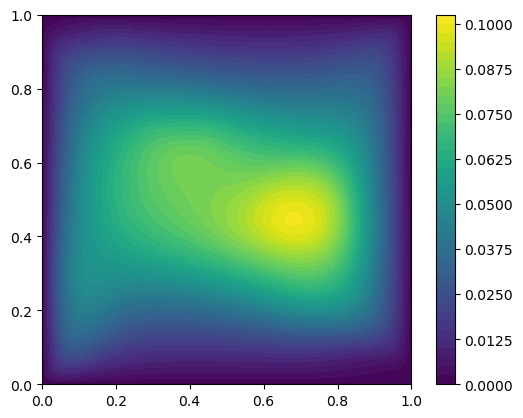

In [16]:
para_true = np.ones((n_para,))
state = fom.solve(parameter=para_true)
fom.plot(state)

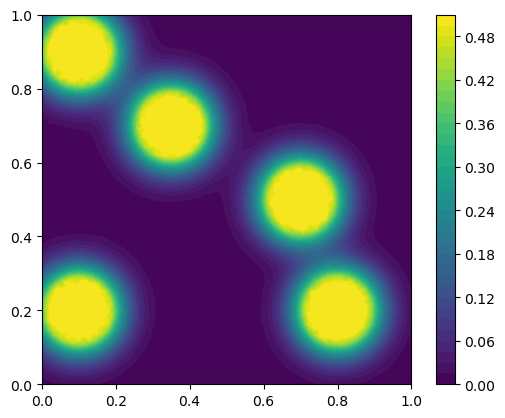

In [17]:
fom.plot(fom.assemble_forcing(para_true))

In [18]:
prior_mean = np.zeros((n_para,))
# prior_mean[0] = 0.5
prior_covar = var_prior*np.eye(n_para)
fom.set_prior(prior_mean=prior_mean, prior_covar=prior_covar)

In [19]:
fom.sample(n_samples = 2)

array([[ 1.53598584,  1.10401218],
       [-0.46503567, -2.07195848],
       [-1.24304065, -1.30138597],
       [-1.44998736,  0.76529912],
       [-0.37764872, -1.54294931]])

In [21]:
from MyCombinedDroneAngular import MyDrone as CombinedDrone
new_drone = CombinedDrone(eval_mode = "point-eval")
new_alpha = np.array([np.pi/2, 0.3, 1, 1, 1, 1, 1])
flightpath, grid_t_drone = new_drone.get_trajectory(alpha=new_alpha)

In [ ]:
class FlightData:
    alpha:np.ndarray = None
    flightpath:np.ndarray = None
    grid_t:np.ndarray = None

In [ ]:
flight = FlightData()
print(flight.grid_t)